<a href="https://colab.research.google.com/github/EmaMule/Computer-Vision/blob/main/notebooks_new_features/GroundDepthMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

**IMPORTANT**: this Python Notebook is intended to be used on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Mu0SlsxwE-nl9W5rOCQCxvP7UQ-AITN6?usp=drive_link#scrollTo=orolNaFWJ---)

In this notebook we compute the depth map of the ground RGB images using the Depth-Anything model from [this paper](https://arxiv.org/abs/2401.10891), in particular the *vitl_14* version, based on Visual Transformers, with pretrained weights.

We load the model, define a custom preprocessing function to avoid downscaling, then apply the model and process its output in the form of an heatmap representing the depth of the image.

# Imports

In [1]:
!git clone https://github.com/LiheYoung/Depth-Anything
!pip install -q -r /content/Depth-Anything/requirements.txt
!pip install -q spaces

Cloning into 'Depth-Anything'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 421 (delta 101), reused 43 (delta 39), pack-reused 277
Receiving objects: 100% (421/421), 237.89 MiB | 22.06 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Updating files: 100% (219/219), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.3 MB/s eta 0:00:00
     

In [2]:
cd Depth-Anything

/content/Depth-Anything


In [3]:
from google.colab import drive


from tqdm import tqdm
import gc

import gradio as gr
import cv2
import numpy as np
import os
from PIL import Image
import spaces
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import tempfile
from gradio_imageslider import ImageSlider

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Model Creation

In [5]:
# define model and build pre-processing function

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = 'vitl'
model = DepthAnything.from_pretrained(f"LiheYoung/depth_anything_{encoder}14").to(device).eval()

transform = Compose([
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method='lower_bound',
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [6]:
@spaces.GPU
@torch.no_grad()
def predict_depth(model, image):
    return model(image)


def obtain_depth_map(model, transform, img_path):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # load the image
    image = Image.open(img_path)
    image = np.array(image)
    original_image = image.copy()
    h, w = image.shape[:2]

    # pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0).to(device)

    # apply the model
    depth = predict_depth(model, image)
    depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]

    # post-process the image
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.cpu().numpy().astype(np.uint8)
    colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)[:, :, ::-1]

    return colored_depth

# Example

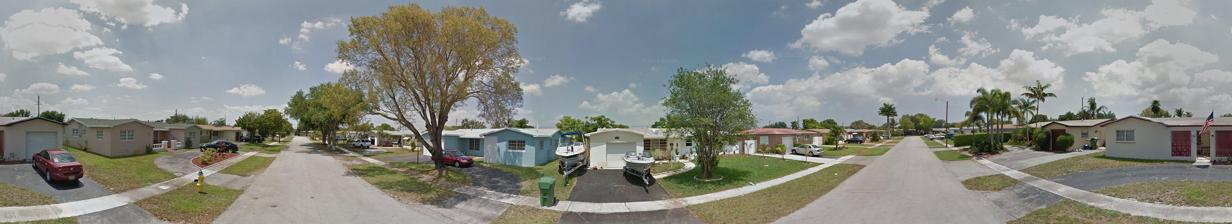

In [7]:
# we take an image from the dataset and load it using PIL

path = '/content/drive/MyDrive/CV Project/CVUSA/streetview/0000194.jpg'

image = Image.open(path)
image

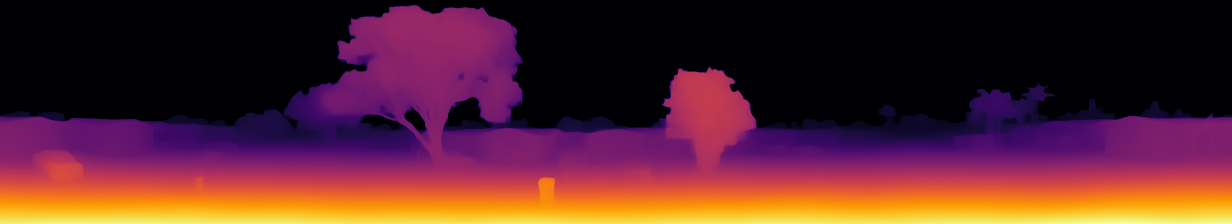

In [10]:
# apply the whole process to the image
colored_depth = obtain_depth_map(model, transform, path)

# represent image
depth_image = Image.fromarray(colored_depth)
depth_image

# Dataset Creation

In [11]:
# here we iterate the defined function over each image in the dataset and save
# them on google drive

target_dir_path = "/content/drive/MyDrive/CV Project/CVUSA/streetview_depth"
dir_path = "/content/drive/MyDrive/CV Project/CVUSA/streetview"


if not os.path.exists(target_dir_path):
    os.makedirs(target_dir_path)


image_names = os.listdir(dir_path)
image_paths = []
for image_name in image_names:
    image_path = os.path.join(dir_path, image_name)
    image_paths.append(image_path)


depth_paths = []
for image_name in image_names:
    image_path = os.path.join(target_dir_path, image_name)
    depth_paths.append(image_path)


for i in tqdm(range(len(image_paths))):
    if i % 200 == 0:
        gc.collect()
        torch.cuda.empty_cache()
    if not os.path.exists(depth_paths[i]):
        colored_depth = obtain_depth_map(model, transform, image_paths[i])
        depth_image = Image.fromarray(colored_depth)
        depth_image.save(depth_paths[i])

100%|██████████| 8862/8862 [01:23<00:00, 106.45it/s]
